<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/master/notebooks/DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentations

Data Augmentations can be an effective means to improving model performance,
especially with limited training data.


In [14]:
import random
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Augmentations for Segmentation

Here we perform data augmentations on images and labels used for baseline
detection.

Given an image and a label, perform a random augmentation that includes
the following:
* Random Affine Transformation
* Random Brightness Transformation
* Random Channel Transformation

Download the Dataset

In [5]:
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WBniZc_NS7mIYNxNm3rt7sJC3LaX2Tpv' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1WBniZc_NS7mIYNxNm3rt7sJC3LaX2Tpv" -O baseline_dataset.zip && rm -rf /tmp/cookies.txt
!unzip -q baseline_dataset.zip
!rm baseline_dataset.zip

In [6]:
!ls

baseline_seams_dataset	sample_data


Create the Keras Sequence to Load Data

In [7]:
class BaselineSequence(tf.keras.utils.Sequence):
  def __init__(self, img_path, label_path, desired_size=(768, 1152)):
    self.img_path = img_path
    self.label_path = label_path

    if not os.path.exists(self.img_path) or not os.path.exists(self.label_path):
      raise Exception('Baseline dataset does not exists in', self.img_path)

    self.desired_size = desired_size
    self.imgs = os.listdir(self.img_path)

  def resize(self, img, desired_size):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = desired_size[0] / desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = desired_size[0]
      new_width = int(desired_size[0] // img_ratio)
    else:
      new_height = int(desired_size[1] * img_ratio)
      new_width = desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = desired_size[0] - new_height
    border_right = desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=0)

    return img

  def tensor_image(self, path, pil_format):
    img = Image.open(path)
    img = img.convert(pil_format)
    img = self.resize(img, self.desired_size)
    x = tf.constant(img, dtype=tf.float32)

    return x

  def __getitem__(self, index):
    img = self.tensor_image(os.path.join(self.img_path, self.imgs[index]), pil_format="L") 
    label = self.tensor_image(os.path.join(self.label_path, self.imgs[index].split('.')[0] + '_gt.jpg'), pil_format="1")

    img = tf.expand_dims(img, 2)
    label = tf.expand_dims(label, 2)

    return img, label
  
  def __len__(self):
    return len(self.imgs)

Function to perform random data augmentation to an image and label.

In [8]:
def random_augmentation(img, label):
  theta = 0
  tx = 0
  ty = 0
  zx = 1
  zy = 1
  shear = 0

  # Random Flip
  if random.randint(0,2) == 0:
    img = tf.image.flip_left_right(img)
    label = tf.image.flip_left_right(label)
  # Random Rotate
  if random.randint(0,1):  # .5
    theta = random.uniform(-5, 5)
  # Random Shear
  elif random.randint(0,1): # Only do shear if we haven't rotated
    shear = random.uniform(-5, 5)
  # Random Zoom
  if random.randint(0,2) == 0:
    zx = random.uniform(0.9, 1.1)
    zy = random.uniform(0.9, 1.1)
  # Random Translation
  if random.randint(0,1):
    tx = random.uniform(-35, 35)
    ty = random.uniform(-35, 35)

  # Apply Affine Transformation
  img = tf.keras.preprocessing.image.apply_affine_transform(img.numpy(), theta=theta, tx=tx, ty=ty, shear=shear, zx=zx, zy=zy)
  label = tf.keras.preprocessing.image.apply_affine_transform(label.numpy(), theta=theta, tx=tx, ty=ty, shear=shear, zx=zx, zy=zy)

  # Apply Random Brightness Transformation
  if random.randint(0,1):
    img = tf.keras.preprocessing.image.random_brightness(img, (.01, 1.4))
  # Apply Random Channel Shift
  else:
    img = tf.keras.preprocessing.image.random_channel_shift(img, 100)
  
  return img, label

Augmentation Results

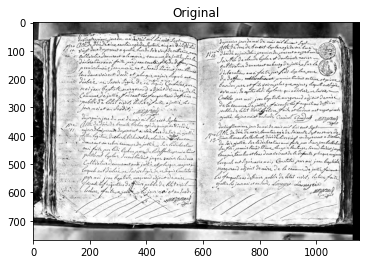

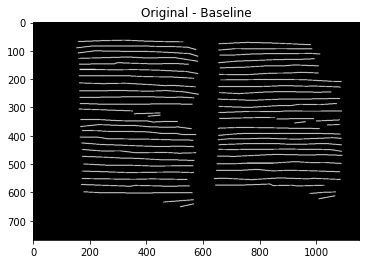

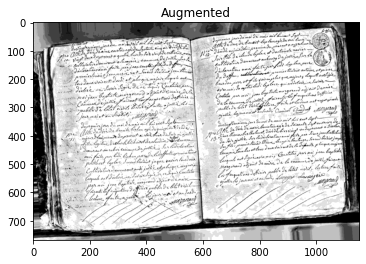

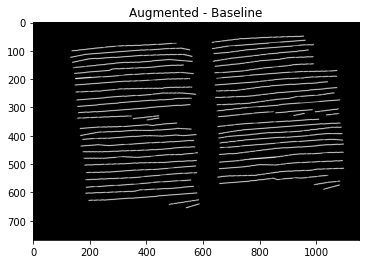

In [18]:
sequence = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines')

img, baseline = sequence[1]
plt.title('Original')
plt.imshow(tf.squeeze(img), cmap='gray')
plt.pause(.1)

plt.title('Original - Baseline')
plt.imshow(tf.squeeze(baseline), cmap='gray')
plt.pause(.1)

img, baseline = random_augmentation(img, baseline)

plt.title('Augmented')
plt.imshow(tf.squeeze(img), cmap='gray')
plt.pause(.1)

plt.title('Augmented - Baseline')
plt.imshow(tf.squeeze(baseline), cmap='gray')
plt.pause(.1)